I need to be able to train a variety of models using a variety of datasets and evaluate their performance in various ways. It would be helpful to develop a framework to train such combinations.

To support generalized usage, compatible datasets should implement a consistent interface:
* Derive from PyTorch Dataset
* Provide methods to query the number of classes, class indices, and class names
* Provide methods to query image dimension

Compatible models should include:
* ?

Compatible evaluators should implement a consistent interface:
* Initialize split (split type)
* Batch statistic (split type, class activations, ground truth)
* Epoch summary
* Training summary

The test framework should provide means to construct an experiment combining dataset, model, and evaluation objects.

Experiment(model, dataset, evaluator)
train(optimizer, ...)
validate

, and 
Develop a generalized classifier development bench. The development should accept an arbitary classificationallow me to create models

object that c
Train Model
Test Model
Save Model
Load Model
Evaluate Model

class Experiment:
    """Classifier experiment test bench.
    """

    def __init__(self, model, dataset, transforms, metrics, hyperparamters):
        
        pass
    
    def train


In [1]:
%reset -f 

# Import a lot of stuff
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
#from dvmcar import DvmCarDataset
from boxcars3d import BoxCars3dDataset

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

local = True

if local:
    #work_def = '/data/dvmcar/dvmcar.zip'
    work_def = '/data/boxcars3d/boxcars3d.zip'    
    persist_def = None
else:
    #work_def = '/home/ubuntu/WorkLab/data/dvmcar/dvmcar.zip'
    work_def = '/home/ubuntu/WorkLab/data/boxcars3d/boxcars3d.zip'
    #persist_def = '/home/ubuntu/worklab/dvmcar.zip'
    persist_def = '/home/ubuntu/worklab/boxcars3d.zip'

# Number of epochs to train for 
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Resnet input height & width?
input_size  = 224

# Training minibatch size
# Higher number are more computationally efficient but might slow convergence
batch_size  = 50

# Shuufle data between epochs
shuffle     = True

# Set the fraction of the dataset to use.
# Normally this should be 1, but values less than one decrease the number of samples per epoch
scale = 1

# Set partions for train, test, and validate subsets
partition0  = 0.8*scale
partition1  = 0.9*scale
partition2  = 1.0*scale

# Define corresponding split arguments for the dataset constructor
train_split = [0,          partition0]
val_split   = [partition0, partition1]
test_split  = [partition1, partition2]

# Specify training transform stack
# Not too sure what random resize crop does...
# Per Derek - maybe color space & other distortions would be useful?
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

# Specify vaidation transform stack
val_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

#train_data  = DvmCarDataset(split = train_split, transform = train_transform, work = work_def, persist = persist_def)
#val_data    = DvmCarDataset(split =   val_split, transform =   val_transform, work = work_def, persist = persist_def)
train_data  = BoxCars3dDataset(split = train_split, transform = train_transform, work = work_def, persist = persist_def)
val_data    = BoxCars3dDataset(split =   val_split, transform =   val_transform, work = work_def, persist = persist_def)

print('Training split contains {:7} images.'.format(len(train_data)))
print('Validation split contains {:7} images.'.format(len(val_data)))

PyTorch Version:  1.11.0
Torchvision Version:  0.12.0
Work file /data/boxcars3d/boxcars3d.zip is already available.
Work file /data/boxcars3d/boxcars3d.zip is already available.
Training split contains   93028 images.
Validation split contains   11629 images.


In [10]:
label_fields = [l.split() for l in train_data.label_list]
mm_fields = list(set([r[0]+','+r[1] for r in label_fields]))
mm_fields.sort()

with open('boxcars_make_model.csv','w') as out:
    out.write('boxcars3d-make,boxcars3d-model\n')
    for r in mm_fields:
        out.write(r+'\n')

In [3]:
%matplotlib inline

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    
    classes = model.fc.out_features
    
    plt.rcParams['figure.dpi'] = 160

    fig = plt.figure() 
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2) 

    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            sample = 0
                       
            rank_count = np.zeros(classes, dtype=np.float)

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                sample += inputs.size(0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    # Use maximal classes as predictions
                    _, preds = torch.max(outputs, 1)
                    
                    # Get indices (labels) sorting the vector in decreasing order
                    top_indices = torch.argsort(outputs, 1, descending=True)
                    
                    # Find predicted ranking of the true class for each result in the batch
                    n = [(top_indices[k]==labels.data[k]).nonzero().squeeze().item() for k in range(len(labels.data))]
                    
                    # For each result in the batch...
                    for idx in n:
                        
                        # Increment
                        rank_count[idx] += 1

                    # Update plot
                    
                    fig.suptitle('Top N Summary: phase={}, epoch={:3}, sample={:8}'.format(
                        phase, epoch, sample))

                    clear_output(wait = True)
                    x = np.arange(classes)+1
                    
                    ax1.cla()
                    ax1.plot(x,          rank_count /sample, label='P(rank==N)')
                    ax1.plot(x,np.cumsum(rank_count)/sample, label='P(rank in 1..N)')
                    ax1.set_title('All classes')
                    ax1.legend()
                    ax1.grid()
                    ax1.set_ylabel('Probability')
                    ax1.set_xlabel('N')    

                    max_n = 20
                    ax2.cla()
                    ax2.plot(x[:max_n],          rank_count[:max_n] /sample, label='P(rank==N)', linestyle='None', marker='o')
                    ax2.plot(x[:max_n],np.cumsum(rank_count[:max_n])/sample, label='P(rank in 1..N)', linestyle='None', marker='o')
                    ax2.set_title('Top {} classes'.format(max_n))
                    ax2.legend()
                    ax2.grid()
                    ax2.set_ylabel('Probability')
                    ax2.set_xlabel('N')    
                    
                    display(fig)    
 
                    print('Epoch={:3} / Sample={:8}'.format(epoch, sample), end='\r', flush=True)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

Initializing Datasets and Dataloaders...
Params to learn:
	 fc.weight
	 fc.bias
Training model...
Epoch 0/9
-


AttributeError: module '__main__' has no attribute '__spec__'

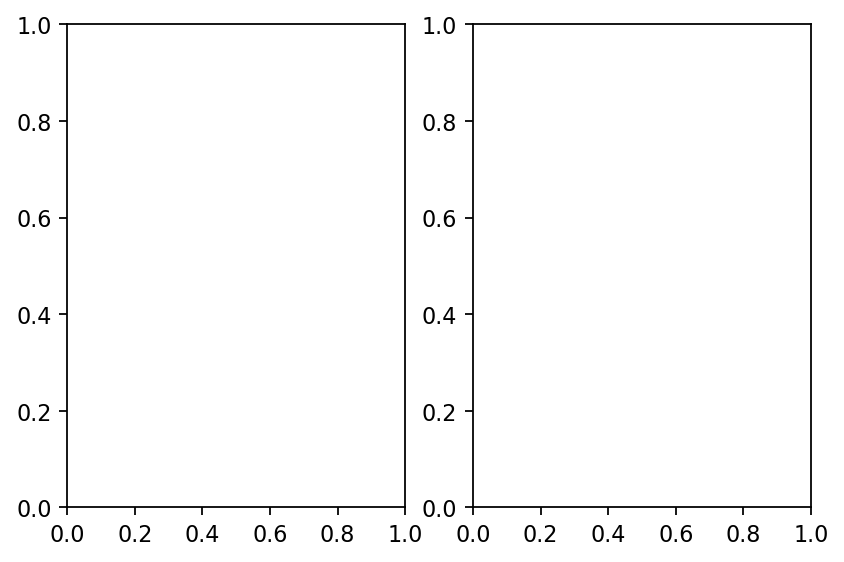

In [12]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, train_data.classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {'train': train_data, 'val' : val_data}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.05)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

print("Training model...")

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [10]:
print(dataloaders_dict['train'])